# Pruning Neural Networks at Init

---

This is a take at pruning Networks before training on MNIST data. The Notebook explains the used operations etc.

## Imports and Data-Preparation

In [335]:
## Settings
model_type = "LeNet5"  ## Choice of "LeNet5" and "Dense"

In [336]:
## Tensorflow related
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
from tensorflow.keras.layers import Conv2D, Dense

## General
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

## Importing Pruned Model
import sys; 
if "..\\" not in sys.path: sys.path.append("..\\")
import src.masked_keras as msk
import src.wrappers as wrp

In [337]:
from importlib import reload
wrp = reload(wrp)
msk = reload(msk)

In [338]:
## Fetch Mnist-Dataset
(X_train, y_train), (X_test, y_test) = wrp.load_mnist() # 10000
num_classes = 10
## Pad if necessairy
if model_type == "LeNet5":
    X_train = np.pad(X_train, ((0,0),(2,2),(2,2),(0,0)), 'constant')
    X_test  = np.pad(X_test,  ((0,0),(2,2),(2,2),(0,0)), 'constant')

---

## Defining the Model, Loss, and Optimizer

In [339]:
## Defining the Model with Sequential API
if model_type == "Dense":
    def get_model():
        return keras.Sequential([
            layers.Flatten(input_shape=X_train.shape[1:]),
            layers.Dense(128, activation="relu"),
            layers.Dense(128, activation="relu"),
            layers.Dense(128, activation="relu"),
            layers.Dense(num_classes, activation="softmax")
        ])

if model_type == "LeNet5":
    def get_model():
        return keras.Sequential([
            layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu', 
                input_shape=X_train.shape[1:]),
            layers.AveragePooling2D(),
            layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'),
            layers.AveragePooling2D(),
            layers.Flatten(),
            layers.Dense(units=120, activation='relu'),
            layers.Dense(units=84, activation='relu'),
            layers.Dense(units=10, activation = 'softmax')
        ])

## Extract init-model weights for training after pruning
model = get_model()
w_init = model.get_weights()

In [340]:
loss_fn = keras.losses.CategoricalCrossentropy()

In [341]:
np.round(wrp.simple_accuracy(model, X_test, y_test), 2)

0.11

In [342]:
print(f"Accuracy at init: {wrp.simple_accuracy(model, X_test, y_test):.2f}")

Accuracy at init: 0.11


---

## GraSP Pruning

Pruning logic by from [Wang, et al. (2020)](https://openreview.net/pdf?id=SkgsACVKPH). They exploit the following property: Let $N, F\in \mathbb N$
$$
    \mathbf f:\mathbb R^F \to \mathbb R^N, \ \mathbf x \mapsto \mathbf f(\mathbf x)\, .
$$
Furthermore let $\mathbf v \in \mathbb R^F$, such that $\mathbf f(\mathbf x)^T\mathbf v \in \mathbb R$. Then
$$\begin{align*}
    \Big[ \nabla_{\mathbf x} \big(\mathbf f(\mathbf x)^T \mathbf v\big)\Big]_i &= \frac{\partial}{\partial x_i} \big(\mathbf f(\mathbf x)^T \mathbf v\big) = \frac{\partial}{\partial x_i} \sum_{j=1}^N f_j(\mathbf x) v_j \\
    &= \sum_{j=1}^N \frac{\partial f_j(\mathbf x)}{\partial x_i} v_j = \big[ D\mathbf f(\mathbf x)^T \,\mathbf v \big]_i \, .
\end{align*}$$
This can be used to calculate Jacobian-vector-producs using only gradients. Specifically for $\mathbf f$ being the gradient of some scalar function $\varphi(\mathbf x)$ this yields for the Hessian-vector-product, denoted as `Hgp` (Hessians are symmetric under smoothness conditions):
$$
    H\varphi(\mathbf x) \, \mathbf v = \nabla \Big( \nabla \varphi^T \mathbf v \Big)\, .
$$
Using the gradient but already evaluated at some $\mathbf x_0$ (equiv to `stop_grad`) this yields the formula used in the paper (p. 5).

Maybe also take a look at the minimal example in the [auxiliary notebook](./_aux.ipynb). Below I show how to also calulate the `Hvp` using a `Forward.Accumulator` which explicitly implements jacobian-vector-products.

In [343]:
## Reset Model
model = get_model()
model.set_weights(w_init)

## GraSp batch:
X_grasp, y_grasp = wrp.random_batch(X_train, y_train, batch_size=512)

In [344]:
## Pruning Scores:
with tf.GradientTape(persistent=True) as outer_tape:
    with tf.GradientTape() as inner_tape:
        y_pred = model(X_grasp)
        loss = loss_fn(y_grasp, y_pred)
    gradients = inner_tape.gradient(loss, model.trainable_variables)
    int_Hgp = tf.reduce_sum([tf.reduce_sum(g * tf.stop_gradient(g)) for g in gradients])
Hgps = outer_tape.gradient(int_Hgp, model.trainable_variables)

In [345]:
## Plain Hessian-gradient-product
with tf.autodiff.ForwardAccumulator(
    model.trainable_variables,
    gradients) as acc:
    with tf.GradientTape() as tape:
        y_pred = model(X_grasp)
        loss = loss_fn(y_grasp, y_pred)
    gradients_new = tape.gradient(loss, model.trainable_variables)
Hgps_acc = acc.jvp(gradients_new)

In [346]:
[np.allclose(Hgp1, Hgp2) for Hgp1, Hgp2 in zip(Hgps, Hgps_acc)]

[True, True, True, True, True, True, True, True, True, True]

In [347]:
## Calculating the scores:
grasp_scores = [w*Hgp for w, Hgp in zip(model.trainable_weights, Hgps)]

## Train a GraSP-pruned Model

In [348]:
grasp_masks = wrp.generate_pruning_mask(grasp_scores, sparsity=0.9)

keras.backend.clear_session()
grasp_kernel = get_model()
grasp_kernel.set_weights(w_init)
grasp_model = msk.StaticMaskedModel(grasp_masks, grasp_kernel)
print(f"Accuracy at init: {wrp.simple_accuracy(grasp_model, X_test, y_test):.2f}")

Accuracy at init: 0.10


In [349]:
grasp_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=loss_fn,
    metrics=["accuracy"]
)

In [350]:
pruned_fit = grasp_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=1,
    batch_size=128
)

469/469 [==============================] - 3s 5ms/step - loss: 1.1638 - accuracy: 0.6178 - val_loss: 0.4229 - val_accuracy: 0.8772


---

## ProsPr Pruning

Pruning logic from [Alizadeh, et al. (2022)](https://arxiv.org/pdf/2202.08132.pdf), but taking care of the pruning step-wise. Custom training loop modified from [Géron (2019)](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/). 

### Plain-Meta Gradient

First I implement the meta-gradient as stated in the reference:
$$
    g = \frac{\partial}{\partial c} \mathcal L(\mathbf{w}_M) = \frac{\partial \mathcal L(\mathbf{w}_M)}{\partial \mathbf{w}_M} \Bigg[ \prod_{m=1}^M \underbrace{\frac{\partial \mathbf{w}_m}{\partial \mathbf{w}_{m-1}}}_{\Gamma_m} \Bigg] \cdot \mathbf{w}_{\textsf{init}}
$$
To enable the autodiff engine to keep track of the masks ($c$'s) it is necessairy to override the forward passes of the model's layers such that the inputs are directly affected by the weights and they can be used as model-parameters. I use a customized "prune loop" through the pruning batches where only the "proper weights" ("\mathbf w"'s) get updated. As stated in the paper, this procedure only allows for a limited number of passes through the batched, because the backpropagation will run out of memory at some point; not that the backpropagation pass for the meta-gradient has to pass through all $M$ forward steps of the "prune loop". This implementation allows for other `keras.optimizers` to be used.

In [351]:
full_mask = [tf.ones_like(w) for w in model.trainable_weights]
masked_model = msk.TrackableMaskedModel(full_mask, model)
optimizer=keras.optimizers.SGD(learning_rate=0.1)

Masking <keras.layers.convolutional.Conv2D object at 0x000001D85928B8E0>
Masking <keras.layers.convolutional.Conv2D object at 0x000001D85928C610>
Masking <keras.layers.core.Dense object at 0x000001DA58552F10>
Masking <keras.layers.core.Dense object at 0x000001DA585542B0>
Masking <keras.layers.core.Dense object at 0x000001DA58554E80>


In [352]:
n_max = 100
with tf.GradientTape() as outer_tape:
    outer_tape.watch(masked_model.masks)
    for n in range(n_max):
        X_batch, y_batch = wrp.non_random_batch(X_train, y_train, n, 256)

        with tf.GradientTape(persistent=True) as inner_tape:
            y_pred = masked_model(X_batch)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + masked_model.losses)
        gradients = inner_tape.gradient(loss, masked_model.proper_weights)
        optimizer.apply_gradients(zip(gradients, masked_model.proper_weights)) 

        print(f"Loss: {loss.numpy():.3f}", end="\r")
     
meta_gradients = outer_tape.gradient(loss, masked_model.masks)
scores_meta_g = wrp.compute_prospr_scores_from_meta_g(meta_gradients)

### "Straming" Meta-Gradients

For this approach I directly calculate the gradient $\gamma_m$ within the "prune loop" after each batch update, i. e. after setting 
$$
    \mathbf{w}_{m+1} = \mathbf w_m - \alpha \frac{\partial \mathcal L(\mathbf{w}_m, \mathcal D_m)}{\partial \mathbf{w}_m} \, ,
$$
and therefore keep track only of the product from the previous equation. This means I use autodiff just to calculate 
$$
    \Gamma_m = \mathbf{1} - \alpha \underbrace{\frac{\partial^2 \mathcal L(\mathbf{w}_{m-1}, \mathcal D_{m-1})}{\partial \mathbf{w}_{m-1}^2}}_{\textsf{Hessian}\ \ H\mathcal L} \, .
$$
With this approach I do not encounter issues with collapsing or exploding gradients. I combine this with the Jacobian times vector trick from [Wang, et al. (2020)](https://openreview.net/pdf?id=SkgsACVKPH), s. t. I do not need to calculate full "Hessians" $\gamma_m$. To see this, let
$$
    \gamma_{< m} = \Bigg[ \prod_{l = 1}^{m-1} \frac{\partial \mathbf w_{l}}{\partial \mathbf w_{l-1}}\Bigg] \mathbf w_{\textsf{init}} = \Bigg[ \prod_{l = 1}^{m-1} \Gamma_l \Bigg] \mathbf w_{\textsf{init}}
$$
Regarding the $\mathbf{w}$'s as $F$-dimensional vectors (the exact shapes get handeled by the autodiff framework) the $\Gamma$'s are $F\times F$ matrices and the $\gamma's$ are therefore yet again $F$-dimensional vectors. Therefore I need to calculate a jacobian times a vector at each step, to keep track of the product as a whole. Computing the full jacobian is expensive but I can use the trick from the GraSp setting yet again, i. e. at each step I update the jacobian-vector-products (`Jvps`) following:
$$
    \Gamma_m \gamma_{<m} = \nabla_{\mathbf w_{m-1}} \big( \mathbf w_m^T \gamma_{<m}\big) \, .
$$
Note that $\Gamma_m$ is symmetric because the identity and $H\mathcal L$ are symmetric.

In [353]:
masked_model.reset(get_model())
[np.allclose(w_new, w_) for w_new, w_ in zip(masked_model.get_proper_weights(), w_init)]

Masking <keras.layers.convolutional.Conv2D object at 0x000001D85B4B5820>
Masking <keras.layers.convolutional.Conv2D object at 0x000001D85B4B5AF0>
Masking <keras.layers.core.Dense object at 0x000001DA4FFD5100>
Masking <keras.layers.core.Dense object at 0x000001DA4FFD53A0>
Masking <keras.layers.core.Dense object at 0x000001DA4FFD5FA0>


[True, True, True, True, True, True, True, True, True, True]

In [354]:
n_max = 200
Jvps = [tf.Variable(var) for var in masked_model.proper_weights]
for n in range(n_max-1):

    X_batch, y_batch = wrp.non_random_batch(X_train, y_train, n, 256)
    w_updates = []
    
    with tf.GradientTape() as outer_tape: ## Pruning Step
        with tf.GradientTape() as inner_tape: # Update Step
            y_pred = masked_model(X_batch, training=True)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + masked_model.losses)
        gradients = inner_tape.gradient(loss, masked_model.proper_weights)
        for w, g in zip(masked_model.proper_weights, gradients):
            w_updates.append(w - 0.1 * g)

        int_Jvps = tf.reduce_sum([tf.reduce_sum(w_ * tf.stop_gradient(v_)) 
            for w_, v_ in zip(w_updates, Jvps)])
    Jvps = outer_tape.gradient(int_Jvps, masked_model.proper_weights)
    for w, w_update in zip(masked_model.proper_weights, w_updates):
        w.assign(w_update) 

    print(f"Loss: {loss.numpy():.3f}", end="\r")

scores_jvp = wrp.compute_prospr_scores(Jvps, masked_model, 
    *wrp.non_random_batch(X_train, y_train, n, 256),
    loss_fn)

In [355]:
masks_meta_g = wrp.generate_pruning_mask(scores_meta_g, 0.9)
masks_jvp = wrp.generate_pruning_mask(scores_jvp, 0.9)

## Train ProsPr-pruned Model

In [356]:
masks = masks_meta_g

In [357]:
keras.backend.clear_session()
model = get_model()
model.set_weights(w_init)

In [358]:
prospr_model = msk.StaticMaskedModel(masks, model)
print(f"Accuracy at init: {wrp.simple_accuracy(prospr_model, X_test, y_test):.2f}")

Accuracy at init: 0.26


In [359]:
prospr_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=loss_fn,
    metrics=["accuracy"]
)

In [360]:
pruned_fit = prospr_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=1,
    batch_size=128
)

469/469 [==============================] - 3s 5ms/step - loss: 1.1073 - accuracy: 0.6640 - val_loss: 0.5518 - val_accuracy: 0.8040


Some sanity Checks:

In [361]:
with tf.GradientTape() as tape:
    y_pred = prospr_model(X_test)
    loss = loss_fn(y_test, y_pred)
gradients = tape.gradient(loss, model.trainable_weights)

In [362]:
## Confirm that the mask has not been trained
[np.all(mm == m) for mm, m in zip(prospr_model.masks, masks)]

[True, True, True, True, True, True, True, True, True, True]

In [363]:
## Sanity Checks
weights_flat = np.concatenate([w.flatten() for w in prospr_model.get_proper_weights()])
masks_flat   = np.concatenate([mask.numpy().flatten() for mask in masks])
grads_flat = np.concatenate([grad.numpy().flatten() for grad in gradients])

weights_zero = np.isclose(weights_flat, 0)
masks_zero = np.isclose(masks_flat, 0)
grads_zero = np.isclose(grads_flat, 0)

print(np.mean(weights_zero == masks_zero))
print(np.mean(grads_zero == masks_zero))

0.9999876838190014
0.6260807448826268


## Sparsity vs. Accuracy

In [364]:
sparsity_range = np.linspace(0.9, 1., 20)

In [365]:
## ProsPr Pruning
prospr_scores = scores_jvp
accuracy_prospr = []
loss_prospr = []

for sparsity in tqdm(sparsity_range):
    masks = wrp.generate_pruning_mask(
        prospr_scores, 
        sparsity=np.clip(sparsity, a_min=0., a_max=1.))
    prospr_model = msk.StaticMaskedModel(masks, keras.models.clone_model(model))
    prospr_model.set_weights(w_init)

    prospr_model.compile(
        optimizer=keras.optimizers.Adam(),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    pruned_fit = prospr_model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        verbose=0,
        epochs=1,
        batch_size=128
    )

    accuracy_prospr.append(pruned_fit.history['val_accuracy'])
    loss_prospr.append(pruned_fit.history['val_loss'])

100%|██████████| 20/20 [00:55<00:00,  2.78s/it]


In [366]:
## GraSP Pruning
accuracy_grasp = []
loss_grasp = []

for sparsity in tqdm(sparsity_range):
    masks = wrp.generate_pruning_mask(
        grasp_scores, 
        sparsity=np.clip(sparsity, a_min=0., a_max=1.))
    grasp_model = msk.StaticMaskedModel(masks, keras.models.clone_model(model))
    grasp_model.set_weights(w_init)

    grasp_model.compile(
        optimizer=keras.optimizers.Adam(),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    pruned_fit = grasp_model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        verbose=0,
        epochs=1,
        batch_size=128
    )

    accuracy_grasp.append(pruned_fit.history['val_accuracy'])
    loss_grasp.append(pruned_fit.history['val_loss'])

100%|██████████| 20/20 [00:55<00:00,  2.75s/it]


In [367]:
## Random Pruning
weight_shapes = [var.shape for var in model.trainable_weights]
accuracy_random = []
loss_random = []

for sparsity in tqdm(sparsity_range):
    masks = wrp.generate_random_pruning_mask(
        weight_shapes, 
        sparsity=sparsity)
    pruned_model = msk.StaticMaskedModel(masks, keras.models.clone_model(model))
    pruned_model.set_weights(w_init)

    pruned_model.compile(
        optimizer=keras.optimizers.Adam(),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    pruned_fit = pruned_model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        verbose=0,
        epochs=1,
        batch_size=128
    )

    accuracy_random.append(pruned_fit.history['val_accuracy'])
    loss_random.append(pruned_fit.history['val_loss'])

100%|██████████| 20/20 [00:55<00:00,  2.77s/it]


In [368]:
labels_acc  = ["rand. pruning acc.",  "ProsPr acc.", "GraSp acc."]
labels_loss = ["rand. pruning loss", "ProsPr loss", "GraSp loss"]
data_acc  = [accuracy_random, accuracy_prospr, accuracy_grasp]
data_loss = [    loss_random,     loss_prospr,     loss_grasp]
lines_acc  = ["k-",  "r-",  "g-"]
lines_loss = ["k--", "r--", "g--"]

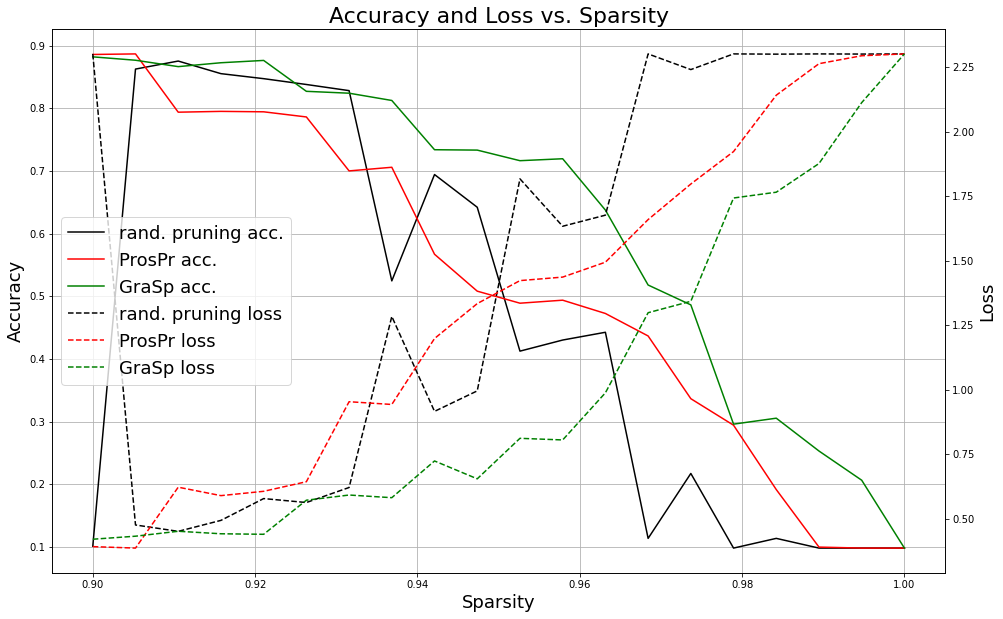

In [369]:
fig, ax0 = plt.subplots(figsize=(16, 10))
ax1 = ax0.twinx()
ax0.set_title("Accuracy and Loss vs. Sparsity", fontsize=22)

plt_acc  = [ax0.plot(sparsity_range, data, line, label=label) 
    for data, line, label in zip(data_acc, lines_acc, labels_acc)]
plt_loss = [ax1.plot(sparsity_range, data, line, label=label) 
    for data, line, label in zip(data_loss, lines_loss, labels_loss)]

ax1.set_ylabel("Loss", fontsize=18)
ax0.set_xlabel("Sparsity", fontsize=18)
ax0.set_ylabel("Accuracy", fontsize=18)
ax0.grid()
lns = [l[0] for l in plt_acc + plt_loss]
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='center left', fontsize=18)
plt.show()
plt.close()